In [1]:
%cd /qbio/ari/works/SCV2_2022_re

/qbio/ari/works/SCV2_2022_re


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})

matplotlib.rcParams['ytick.labelright'] = True
matplotlib.rcParams['ytick.labelleft'] = False
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.left'] = False

In [4]:
orfcolors = {'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

In [5]:
anno = pd.read_csv('hy_/refs/SARS-CoV-2-annotations.gff'
                   , sep='\t', names=['chrom', 'type', 'name', 'start', 'end', 'x', 'y', 'z'])
cdsanno = anno[anno['type'] == 'CDS']
cdsanno = cdsanno.iloc[:10].sort_values(by='start').iloc[:9]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([
        pd.Series(['chrSCV', 'CDS', 'ORF1a', 266, 13468, '.', '.', '.'], index=cdsanno.columns),
        pd.Series(['chrSCV', 'CDS', 'ORF1b', 13468, 21552, '.', '.', '.'], index=cdsanno.columns),
    ])])
cdsanno = cdsanno.sort_values(by='start').iloc[:, 2:5].reset_index(drop=True)
cdsanno['color'] = cdsanno['name'].apply(orfcolors.__getitem__)
#cdsanno.to_pickle('tmp/cdsannotation.pickle')
cdsanno

from Bio import Seq
from Bio import SeqIO

reference_sequence = 'hy_/refs/SARS-CoV-2-RNA.fa'
refseq = str(next(SeqIO.parse(reference_sequence, 'fasta')).seq).upper().replace('T', 'U')

In [6]:
SAMPLES_ALL = 'Korea_2020 Freiburg_2020_1 IVT_1 IVT_2'.split(' ')
SAMPLES_VIRAL = 'Korea_2020 Freiburg_2020_1'.split(' ')
SAMPLES_CTL = 'IVT_1 IVT_2'.split(' ')

In [9]:
viral_colors = {'Korea_2020':'crimson',
                'Freiburg_2020_1':'dodgerblue',
               }
sample_anno = {'Korea_2020': 'Kim, 2020',
             'Freiburg_2020_1': 'Miladi, 2020',
              'IVT_1': 'IVT 1',
               'IVT_2': 'IVT 2'}

In [ ]:
RCS_modfracs = []
for i, file in enumerate(['eligos2/pairdiff/RCS/Korea_2020/Korea_2020.genome.sorted_vs_IVT_1.genome.sorted_on_ont-refs_combine.txt',
                        'eligos2/pairdiff/RCS/Korea_2020/Korea_2020.genome.sorted_vs_IVT_2.genome.sorted_on_ont-refs_combine.txt',
                        'eligos2/pairdiff/RCS/Freiburg_2020_1/Freiburg_2020_1.genome.sorted_vs_IVT_1.genome.sorted_on_ont-refs_combine.txt',
                        'eligos2/pairdiff/RCS/Freiburg_2020_1/Freiburg_2020_1.genome.sorted_vs_IVT_1.genome.sorted_on_ont-refs_combine.txt'],
                        ):
    stats = pd.read_csv(file, sep = '\t')
    name = SAMPLES_VIRAL[i//2]
    ivt = SAMPLES_VIRAL[i%2]
    stats['sample'] = name
    stats['rep'] = ivt
    RCS_modfracs.append(stats)
RCS_modfracs = pd.concat(RCS_modfracs).sort_values(by=['start_loc', 'sample'])
RCS_modfracs = RCS_modfracs.reset_index(drop=True)
    

In [13]:
import pickle

with open("fig_pickle/eligos2_RCS.pickle", "wb") as f:
    pickle.dump(RCS_modfracs, f)

In [94]:
with open("fig_pickle/eligos2_RCS.pickle", "rb") as f:
    RCS_modfracs = pickle.load(f)

In [95]:
RCS_modfracs = RCS_modfracs[RCS_modfracs['test_cor_1']+RCS_modfracs['test_err_1']>=500]
RCS_modfracs = RCS_modfracs[RCS_modfracs['ctrl_cor_1']+RCS_modfracs['ctrl_err_1']>=500]
RCS_modfracs = RCS_modfracs[RCS_modfracs['homo_seq']=='--']

In [10]:
modfracs = []
for file, name in zip([f'eligos2/pairdiff/{name}/combine.txt' for name in SAMPLES_VIRAL],
              SAMPLES_VIRAL):
    stats = pd.read_csv(file, sep = '\t')
    stats['sample'] = name
    modfracs.append(stats)

modfracs = pd.concat(modfracs).sort_values(by=['start_loc', 'sample'])
modfracs = modfracs.reset_index(drop=True)


In [15]:
with open("fig_pickle/eligos2_total.pickle", "wb") as f:
    pickle.dump(modfracs, f)

In [30]:
modfracs = modfracs[modfracs['ctrl_err_1']+modfracs['ctrl_cor_1']>=500]
modfracs = modfracs[modfracs['test_err_1']+modfracs['test_cor_1']>=500]
modfracs = modfracs[modfracs['homo_seq']=='--']

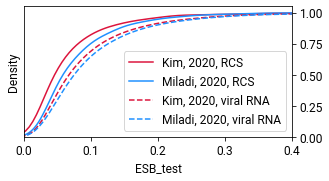

In [96]:
fig, ax = plt.subplots(1,1, figsize=(4.8, 2.4))
for name in SAMPLES_VIRAL:
    plotdf = RCS_modfracs[RCS_modfracs['sample']==name]
    sns.kdeplot(plotdf['ESB_test'],
               cumulative=True, color=viral_colors[name],
               label=f'{sample_anno[name]}, RCS')
ax.legend()

ax.set_xlim(0, 0.4)

for name in SAMPLES_VIRAL:
    plotdf = modfracs[modfracs['sample']==name]
    sns.kdeplot(plotdf['ESB_test'],
               cumulative=True, color=viral_colors[name],
               label=f'{sample_anno[name]}, viral RNA', linestyle='--')

ax.legend()

ax.set_xlim(0, 0.4)
fig.savefig('figfinal/ESB_curv.pdf')

In [82]:
frp_esb = np.percentile(RCS_modfracs['ESB_test'], 95)
frp_oddR = np.percentile(RCS_modfracs['oddR'], 95)

In [83]:
frp_oddR

1.8085510427997695

In [84]:
MIN_COV = 500
MIN_ODDR = frp_oddR
AGG_DIS = 4
MIN_MODFRAC = frp_esb
MAX_PVALUE = 0.05

class eligos2:
    
    def __init__(self, filelist, samples):
        self.filelist = filelist
        self.samples = samples
        self.max_distance = 4
        self.minimum_coverage = MIN_COV
    
    def load_combine_all(self):
        modfracs = []
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = '\t')
            stats['sample'] = name
            modfracs.append(stats)

        modfracs = pd.concat(modfracs).sort_values(by=['start_loc', 'sample'])
        modfracs = modfracs.reset_index(drop=True)
        return(modfracs)

    def get_modified_sites(self, pvalue=0.05, hp_filter=True):
        positive_positions = set()
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = '\t')
            if hp_filter:
                stats = stats[stats['homo_seq']=='--']

            stats_high = stats[(stats['test_cor_1']+stats['test_err_1']>= MIN_COV) &
                               (stats['ctrl_cor_1']+stats['ctrl_err_1']>= MIN_COV) &
                                   (stats['oddR'] >= MIN_ODDR) &
                              (stats['adjPval']<=MAX_PVALUE)&
                              (stats['ESB_test']>=0.01)]
            positive_positions |= set(stats_high['end_loc'].tolist())

        modfracs=[]
        for file, name in zip(self.filelist, self.samples):
            stats = pd.read_csv(file, sep = '\t')
            stats['sample'] = name
            modfracs.append(stats[stats['end_loc'].isin(positive_positions)])


        if len(modfracs) > 0:
            ret = pd.concat(modfracs).sort_values(by=['end_loc', 'sample']).reset_index(drop=True)
            return ret

    def aggregate_adjacent_sites(self, modfracs):

        modsites_raw = sorted(modfracs['end_loc'].unique())
        continuity = np.diff(modsites_raw) <= self.max_distance
        
        modsite_groups = [[modsites_raw.pop(0)]]
        for pos, cont in zip(modsites_raw, continuity):
            if cont:
                modsite_groups[-1].append(pos)
            else:
                modsite_groups.append([pos])

        purified = []
        for modsites in modsite_groups:
            modfracsites = modfracs[modfracs['end_loc'].isin(modsites)]

            modfracsites_high = modfracsites[modfracsites['total_reads'] >= self.minimum_coverage]
            maxpos = modfracsites.loc[modfracsites_high['oddR'].idxmax()]
            purified.append(modfracsites[modfracsites['end_loc'] == maxpos['end_loc']])

        return pd.concat(purified)
    
    def summarize_into_table(self, aggrtbl):
        mod_frac_all = pd.pivot_table(aggrtbl, columns='sample', values=['oddR'],
                                     index=['end_loc', 'strand'])['oddR'].copy()
        coverage = pd.pivot_table(aggrtbl, columns='sample', values=['total_reads'],
                                 index=['end_loc', 'strand'])['total_reads'].copy()
        esb = pd.pivot_table(aggrtbl, columns='sample', values=['ESB_test'],
                                 index=['end_loc', 'strand'])['ESB_test'].copy()
        return esb, mod_frac_all, coverage


def add_context_info(sitemodfrac, refseq, flanksize):
    context_list=[]
    for pos, strand in sitemodfrac.index:
        pos = pos -1 # one based in end_loc
        context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
        if strand =='-':
            context = str(Seq.Seq(context).reverse_complement())
        else:
            context = context
        context_list.append(context)
        
    return(context_list)


eligos2_analysis = eligos2([f'eligos2/pairdiff/{name}/combine.txt' for name in SAMPLES_VIRAL],
              SAMPLES_VIRAL)
eligos2_modfracs = eligos2_analysis.load_combine_all()

eligos2_freqmods = eligos2_analysis.get_modified_sites()
eligos2_psites = eligos2_analysis.aggregate_adjacent_sites(eligos2_freqmods)

eligos2_esb, eligos2_sitemodfrac, eligos2_sitecov= eligos2_analysis.summarize_into_table(eligos2_psites)

eligos2_sitemodfrac['context'] = add_context_info(eligos2_sitemodfrac, refseq, 10)

eligos2_sitemodfrac = eligos2_sitemodfrac.reset_index().set_index('end_loc')

In [107]:
with open("fig_pickle/eligos2_sitemodfrac.pickle", "wb") as f:
    pickle.dump(eligos2_sitemodfrac, f)

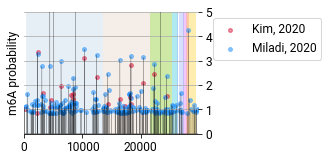

In [108]:
fig, ax = plt.subplots(1,1, facecolor='white', figsize=(4.8,2.4))

for sample in SAMPLES_VIRAL:
    
    name = sample
    plot_x = np.arange(len(refseq))
    plot_y = np.zeros(len(refseq))
    tempfrac = eligos2_sitemodfrac[eligos2_sitemodfrac[name]>=MIN_ODDR]

    plot_y[tempfrac[name].index] = np.log2(tempfrac[name])
    
    ax.scatter(tempfrac.index, np.log2(tempfrac[name]),
                alpha=.5, s=15, label=sample_anno[name], c=viral_colors[name])
    
    ax.plot(plot_x, plot_y, color='black', alpha=.5, lw=.3)
ax.set_xlim(0, len(refseq))
ax.legend()
ax.set_ylabel('m6A probability')


for spside in 'top left right'.split():
    plt.setp(ax.spines[spside], visible=False)

ax.grid(True)
plt.setp(ax.get_xgridlines(), visible=False)

for _, row in cdsanno.iterrows():
    ax.axvspan(row['start'], row['end'], fc=row['color'], alpha=.4, zorder=0)
ax.set_ylim(0, 5)
plt.tight_layout()
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()
fig.savefig('figfinal/eligos2_output_2.pdf')

In [91]:
def meme(posdf):
    with open('temp_fasta.fa', 'w') as outpfile:
        for _, line in posdf.iterrows():
            #strand = line['strand']
            strand = '+'
            pos = _-1
            flanksize = 10
            context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
            
            if strand =='-':
                context = str(Seq.Seq(context).reverse_complement())
            else:
                context = context
            print(f'>{pos},{strand}', file=outpfile)
            print(context, file=outpfile)

The output directory 'meme_eligos2/' already exists.
Its contents will be overwritten.
CD: cefrac 0.25 length 21 central region 4
BACKGROUND: using background model of order 0
PRIMARY (cd): n 207 p0 103 p1 52 p2 52
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p1; pvalue: p2; nsites: p0,p1,p2
Option '-maxw' is greather than the length of longest sequence (21).  Setting '-maxw' to 21.
SEEDS: maxwords 4347 highwater mark: seq 207 pos 13
BALANCE: samples 207 chars 4347 nodes 1 chars/node 4347

seqs=   207, min_w=  21, max_w=   21, total_size=     4347

motif=1
SEED DEPTHS: 2 4 8 16 32 64 103
SEED WIDTHS: 8 11 15 21
em: w=  11, psites= 103, iter=  40 



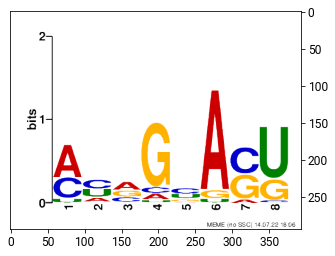

In [103]:
meme(eligos2_sitemodfrac[eligos2_sitemodfrac['Freiburg_2020_1']<=30])
!conda run -n meme meme temp_fasta.fa -oc meme_eligos2/ -rna  -objfun cd -mod zoops

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('meme_eligos2/logo1.png')
imgplot = plt.imshow(img)